# 回归问题：预测房价

在一个回归问题中，我们的目的是预测一个连续的值，比如说房价或者是一个概率。而分类问题则是预测出一个离散的标签。

在这个文档中，我们来预测20世纪70年代中期波士顿的房价。
为了完成这个任务，我们输入一些特征数据以构建模型，例如犯罪率和地产税等，来预测房价。

源文档：[Predict house prices: regression](https://www.tensorflow.org/tutorials/keras/basic_regression)

比较有用的英文词汇：

|  英文  |  中文  | 例句|
| ---- | ---- | ---- |
|  Contrast this with xx  |  相比较于 xx  | |
|  Per capita  |  人均的  | |
|  elapses   |  白白流失掉 | A set amount of epochs elapses without showing improvement |


In [1]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
from tensorflow import keras

import numpy as np

print(tf.__version__)

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


1.10.0


## 下载波士顿房价数据集

In [2]:
boston_housing = keras.datasets.boston_housing

(train_data, train_labels), (test_data, test_labels) = boston_housing.load_data()

# Shuffle the training set
order = np.argsort(np.random.random(train_labels.shape))
train_data = train_data[order]
train_labels = train_labels[order]

57344/57026 [==============================] - 0s 0us/step


### 来看看这些数据

这个数据集比我们以前用过的Minist，电影评价数据集都要小。它里面只有506组数据，被分为404个训练数据和102个测试数据。

In [3]:
print("Training set: {}".format(train_data.shape))  # 404 个训练数据, 每组 13 个特征
print("Testing set:  {}".format(test_data.shape))   # 102 个测试数据, 每组 13 个特征

Training set: (404, 13)
Testing set:  (102, 13)


In [4]:
train_data[0]

array([7.8750e-02, 4.5000e+01, 3.4400e+00, 0.0000e+00, 4.3700e-01,
       6.7820e+00, 4.1100e+01, 3.7886e+00, 5.0000e+00, 3.9800e+02,
       1.5200e+01, 3.9387e+02, 6.6800e+00])

每个数据包含13个特征：
1. 人均犯罪率
1. 占地面积超过25,000平方英尺的住宅用地比例
1. 每个城镇非零售业务的比例
1. 是否临近查尔斯河（如果在河边则= 1;否则为0）
1. 一氧化氮浓度（每千万份）
1. 每栋住宅的平均房间数
1. 1940年以前建造的自住住宅比例
1. 到波士顿五个就业中心的加权距离
1. 径向可以到达高速公路的指数
1. 每10,000美元的全额物业税率
1. 学生和老师的比例
1. $1000*(B_k - 0.63)^2$ 其中$B_k$是城镇黑人的比例。
1. 人口比例较低的百分比。

这些输入数据的特征都按照不同比例存储。一些特征被归一化在0和1之间，另一些则在1到12之间，还有从0到100的，等等。
这种情况在真实世界数据中是经常出现的，我们要了解如何去预处理这些数据。

在这里我们使用pandas显示其中的前几行数据：

In [5]:
import pandas as pd

column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
                'TAX', 'PTRATIO', 'B', 'LSTAT']

df = pd.DataFrame(train_data, columns=column_names)
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.07875,45.0,3.44,0.0,0.437,6.782,41.1,3.7886,5.0,398.0,15.2,393.87,6.68
1,4.55587,0.0,18.10,0.0,0.718,3.561,87.9,1.6132,24.0,666.0,20.2,354.70,7.12
2,0.09604,40.0,6.41,0.0,0.447,6.854,42.8,4.2673,4.0,254.0,17.6,396.90,2.98
3,0.01870,85.0,4.15,0.0,0.429,6.516,27.7,8.5353,4.0,351.0,17.9,392.43,6.36
4,0.52693,0.0,6.20,0.0,0.504,8.725,83.0,2.8944,8.0,307.0,17.4,382.00,4.63


In [6]:
## 显示前几行数据的标签

print(train_labels[0:10])

[32.  27.5 32.  23.1 50.  20.6 22.6 36.2 21.8 19.5]


### 数据归一化

虽然模型可能在即使没有特征归一化的情况下收敛，但它使训练更加困难，并且它使得结果模型更依赖于输入。

我们推荐使用不同的尺度和范围来归一化数据。对于每一个特征，我们**减去特征的平均值并除以标准差**：

In [8]:
# 计算均值和标准差时不可以包含测试数据

mean = train_data.mean(axis=0)
std = train_data.std(axis=0)
train_data = (train_data - mean) / std
test_data = (test_data - mean) / std

print(train_data[0])  # 归一化完成的测试样本（第一个）

[-0.39725269  1.41205707 -1.12664623 -0.25683275 -1.027385    0.72635358
 -1.00016413  0.02383449 -0.51114231 -0.04753316 -1.49067405  0.41584124
 -0.83648691]


## 创建模型

我们创建一个顺序模型，包含两个全连接的隐藏层，以及一个只有一个神经元的输出层，它输出一个连续值。我们把模型的建立包装在一个函数 build_model 里面。

In [10]:
def build_model():
    model = keras.Sequential([
    keras.layers.Dense(64, activation=tf.nn.relu,
                       input_shape=(train_data.shape[1],)),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(1)
    ])

    optimizer = tf.train.RMSPropOptimizer(0.001)

    #以均方差误差MSE进行优化
    model.compile(loss='mse',
                optimizer=optimizer,
                  # 回归指标设置为平均绝对误差MAE
                metrics=['mae'])
    return model

model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                896       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________


## 训练模型

我们迭代500次以训练模型，然后把训练过程中的结果保存在history对象里。

In [11]:
# 将训练过程显示为一个小点儿
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 500

# 存储训练过程状态
history = model.fit(train_data, train_labels, epochs=EPOCHS,
                    validation_split=0.2, verbose=0,
                    callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

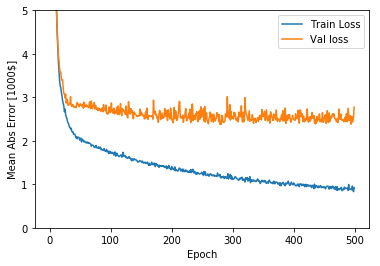

In [13]:
# 我们可视化训练过程中的状态。我们希望使用这些数据以了解这个模型我们需要训练多长时间

import matplotlib.pyplot as plt


def plot_history(history):
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [1000$]')
  plt.plot(history.epoch, np.array(history.history['mean_absolute_error']),
           label='Train Loss')
  plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']),
           label = 'Val loss')
  plt.legend()
  plt.ylim([0, 5])
  plt.show()

plot_history(history)

这个图显示在200个迭代之后，模型只有很微小的长进。我们更新 model.fit 方法，在验证精度不在长进时让训练函数自动停止。
我们使用一个callback来测试每一个迭代训练状态。
如果某一个迭代没有对优化模型起到任何作用，训练过程会自动停止。


....................................................................................................
....................................................................................

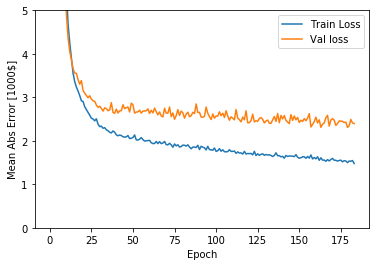

In [14]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = model.fit(train_data, train_labels, epochs=EPOCHS,
                    validation_split=0.2, verbose=0,
                    # 自动停止，在迭代后自动画点
                    callbacks=[early_stop, PrintDot()])
#绘图
plot_history(history)

这个图显示平均误差大约是 2,000 美元。
这个结果好吗？不好！
当一些房价只有15,000美元的时候2,000美元可不是小数额。

让我们看看在测试数据上的平均误差：

In [16]:
[loss, mae] = model.evaluate(test_data, test_labels, verbose=0)

print("在测试数据上的平均误差: ${:7.2f}".format(mae * 1000))

在测试数据上的平均误差: $2982.11


## 预测

最后，我们预测测试数据中的房价数据

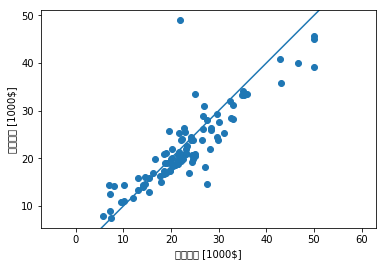

In [23]:
# model.predict(test_data)输出的是一个二维数组[[房价1],[房价2]]，.flatten()将其展平为一个一维数组[房价1, 房价2]
test_predictions = model.predict(test_data).flatten()
plt.scatter(test_labels, test_predictions)
plt.xlabel('真实房价 [1000$]')
plt.ylabel('预测房价 [1000$]')
plt.axis('equal')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
_ = plt.plot([-100, 100], [-100, 100])

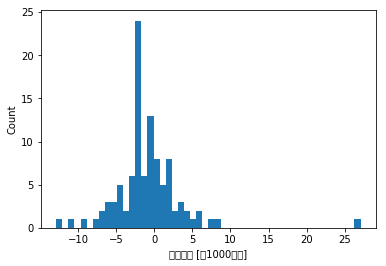

In [24]:
error = test_predictions - test_labels
plt.hist(error, bins = 50)
plt.xlabel("预测误差 [每1000美元]")
_ = plt.ylabel("Count")

## 结论

- 均方差误差（MSE）是一个用于回归问题的基本损失函数，和在分类问题中不一样。
- 同样，相应的评价指标较分类问题也有所不同。 常见的回归指标是平均绝对误差（MAE）。
- 当输入数据具有不同范围的值时，每个特征要单独进行缩放和归一化。
- 如果没有特别多的数据时，最好构建一个隐藏层较小的网络以减少过拟合。
- Early Stopping可以用来预防过拟合。